In [6]:
!pip install opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 MB 13.0 MB/s eta 0:00:0000:0100:01


In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
# This function will return us the image stats
# We input an image in the L*a*b* color space and it returns
# a tuple of mean and std for L*, a* and b* respectively.
def image_stats(image):
    # Compute the mean and standard deviation of each channel
    (l, a, b) = cv2.split(image)
    (l_mean, l_std) = (l.mean(), l.std())
    (a_mean, a_std) = (a.mean(), a.std())
    (b_mean, b_std) = (b.mean(), b.std())

    # return the color statistics
    return (l_mean, l_std, a_mean, a_std, b_mean, b_std)


# This function will perform color transfer from one input image (source)
# onto another input image (destination)
def color_transfer(source, destination):
    # Convert the images from the RGB to L*a*b* color space, being
    # sure to utilizing the floating point data type (note: OpenCV
    # expects floats to be 32-bit, so use that instead of 64-bit)
    source = cv2.cvtColor(source, cv2.COLOR_BGR2LAB).astype("float32")
    destination = cv2.cvtColor(destination, cv2.COLOR_BGR2LAB).astype("float32")

    # Compute color statistics for the source and destination images
    (l_mean_src, l_std_src, a_mean_src, a_std_src, b_mean_src, b_std_src) = image_stats(source)
    (l_mean_dest, l_std_dest, a_mean_dest, a_std_dest, b_mean_dest, b_std_dest) = image_stats(destination)

    # Subtract the means from the destination image
    (l, a, b) = cv2.split(destination)
    l -= l_mean_dest
    a -= a_mean_dest
    b -= b_mean_dest

    # Scale by the standard deviations
    l = (l_std_dest / l_std_src) * l
    a = (a_std_dest / a_std_src) * a
    b = (b_std_dest / b_std_src) * b

    # Add in the source mean
    l += l_mean_src
    a += a_mean_src
    b += b_mean_src

    # Clip the pixel intensities to [0, 255] if they fall outside this range
    l = np.clip(l, 0, 255)
    a = np.clip(a, 0, 255)
    b = np.clip(b, 0, 255)

    # Merge the channels together and convert back to the RGB color space,
    # being sure to utilize the 8-bit unsigned integer data type.
    transfer = cv2.merge([l, a, b])
    transfer = cv2.cvtColor(transfer.astype("uint8"), cv2.COLOR_LAB2BGR)

    # Return the color transferred image
    return transfer


def show_image(title, image, width = 300):
    # Resize the image to have a constant width, just to make displaying the
    # images take up less screen space
    r = width / float(image.shape[1])
    dim = (width, int(image.shape[0] * r))
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

    # Show the resized image
    #cv2.imshow(title, resized)
    resized = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    plt.title(title)
    plt.imshow(resized)
    plt.show()

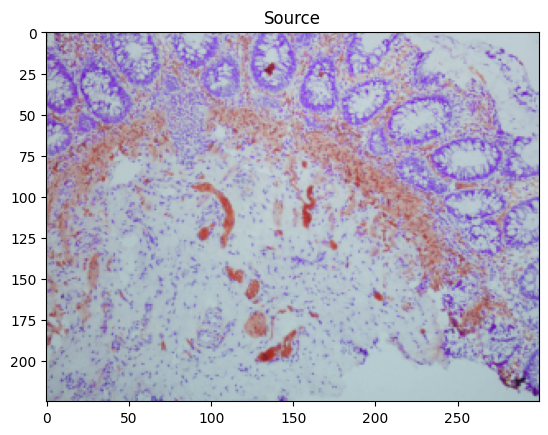

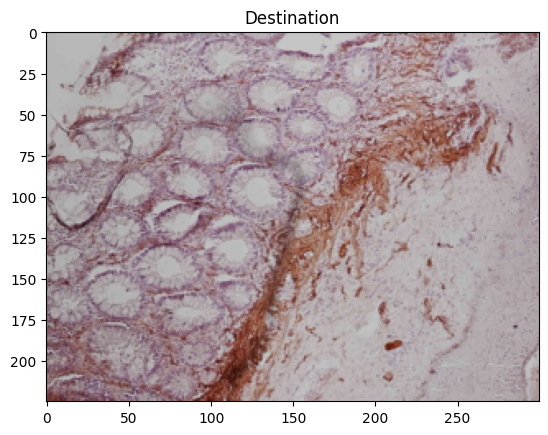

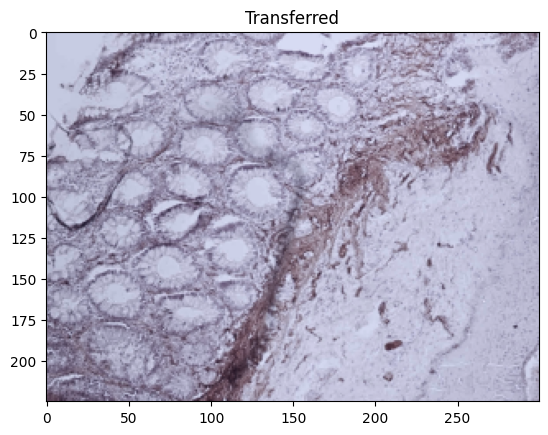

In [3]:
# Image file names
source = "source.jpg"
destination = "dest.jpg"
output = "transferred.jpg"

# Read the images
source = cv2.imread(source)
destination = cv2.imread(destination)

# Transfer the color from source to destination
transferred = color_transfer(source, destination)

# Write the image onto disk (if output is not None)
if output is not None:
    cv2.imwrite(output, transferred)

#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#im_pil = Image.fromarray(img)
# Show the images
show_image("Source", source)
show_image("Destination", destination)
show_image("Transferred", transferred)
#cv2.waitKey(0)

In [5]:
from PIL import Image


def normalizeStaining(img, saveFile=None, Io=240, alpha=1, beta=0.15):
    ''' Normalize staining appearence of H&E stained images
    
    Example use:
        see test.py
        
    Input:
        I: RGB input image
        Io: (optional) transmitted light intensity
        
    Output:
        Inorm: normalized image
        H: hematoxylin image
        E: eosin image
    
    Reference: 
        A method for normalizing histology slides for quantitative analysis. M.
        Macenko et al., ISBI 2009
    '''
             
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
        
    maxCRef = np.array([1.9705, 1.0308])
    
    # define height and width of image
    h, w, c = img.shape
    
    # reshape image
    img = img.reshape((-1,3))

    # calculate optical density
    OD = -np.log((img.astype(float)+1)/Io)
    
    # remove transparent pixels
    ODhat = OD[~np.any(OD<beta, axis=1)]
        
    # compute eigenvectors
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
    
    #eigvecs *= -1
    
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3])
    
    phi = np.arctan2(That[:,1],That[:,0])
    
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)
    
    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)
    
    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:
        HE = np.array((vMin[:,0], vMax[:,0])).T
    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T
    
    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T
    
    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]
    
    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])
    
    # recreate the image using reference mixing matrix
    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  
    
    # unmix hematoxylin and eosin
    H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
    H[H>255] = 254
    H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)
    
    E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
    E[E>255] = 254
    E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)
    
    if saveFile is not None:
        Image.fromarray(Inorm).save(saveFile+'.png')
        Image.fromarray(H).save(saveFile+'_H.png')
        Image.fromarray(E).save(saveFile+'_E.png')

    return Inorm, H, E

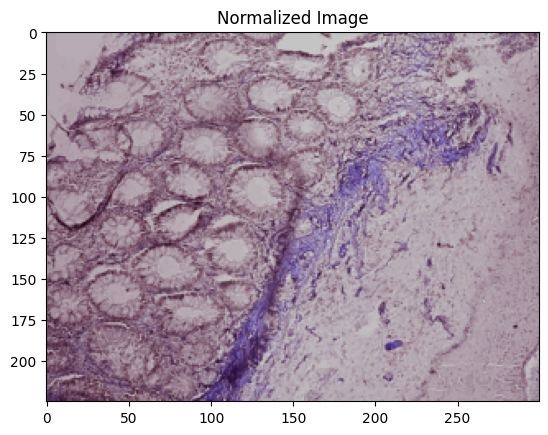

In [6]:
#img = Image.open(destination)
destination = cv2.cvtColor(destination, cv2.COLOR_BGR2RGB)
img = np.array(destination)

norm , _ , _ = normalizeStaining(img, Io=200)

show_image("Normalized Image", norm)